<img src='../source_figures/bnl_logo_horizontal_rgb.png' width="400" height="400">

# steady as beamlines go

### Anomaly Detection with ML and Scalar Time Series

### Andi Barbour, Soft X-ray Scattering and Spectroscopy, CSX, NSLS-II

### NSLS-II and CFN Users' Meeting 2022
Workshop 6

Notebook #2

In [1]:
from matplotlib import cm, patches, pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from itertools import cycle

import collect_ts as ts
from anomaly.extract_features import get_features_single_datum

In [2]:
import pickle
import os.path


In [3]:
def make_the_model_go(model, input_data):
    prediction = "anomaly" if model.predict(input_data) == -1 else "normal"
    print(f"The model characterize the data as {prediction}")

def summarize_runs(runs, name_order):
    for run in runs:
        df = run["baseline"]["data"].read(name_order).to_dataframe()
        print(run.start["scan_id"], run.start["detectors"], run.start.get("purpose","no induced ?"), run.start.get('artifact', "no induced ?"))# "--"*10)
        print("--"*50)
        if df is not None:
            display(df[name_order].mean()) # FOR USER TO TRY - what happens when you remove .mean()

        print(f'{run.stop["exit_status"]:>60} {run.metadata["summary"]["duration"]/60:.2f} minutes')# "--"*10)
        
        
from ipywidgets import interact 

def browse_3Darray(res,title='Frame'):
    """ Widget for notebooks.  Sliding bar to browse 3D python array.
    res         :  3D array with the first element being interated
    dark_gain   :  string to be the title of the plot
                   match dark gain settings as described in the start document ('auto', 'x2', 'x1')
    """   
    N = len(res)
    def view_image(i=0):
        im.set_data(res[i])
        ax.set_title(f'{title} {i}')
        fig.canvas.draw_idle()
    interact(view_image, i=(0, N-1))
    
#%matplotlib widget

In [4]:
from databroker.queries import TimeRange, RawMongo
from tiled.client import from_uri
c = from_uri("https://tiled-demo.blueskyproject.io/api")
csx = c["csx"]["raw"]

# Anoamaly Detection
### With 3 models: *EE*, *IFT*, *LOD* 
* Data is characterized by models as `"normal"` or `"anomaly"`
* All data is from CSX using the FastCCD with various x-ray scattering geometries

[see all training and testing code + data](https://github.com/bnl/pub-ML_examples)

# Load the Model
### Objective
* Use models on data in a serial fasshion (streaming documents)
* See how generalizable the models are
* Get a feel for data collection process prior to training 

In [5]:
models = {}
model_types = ['EE', 'IFT', 'LOD']
for mod_type in model_types:
    with open(f'models/anomaly_detection_{mod_type}_model.pk', 'rb') as f:
        temp = pickle.load(f)
        models.update({mod_type : temp})

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator PCA from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator EllipticEnvelope from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results

In [6]:
scans = [x for x in range(154685, 154696+1)]

In [7]:
runs = csx.search(RawMongo(start={"purpose": "laser stability",}))
runs

<Catalog {154685, 154686, 154687, 154688, 154689, 154690, ...} ~12 entries>

In [8]:
for i, run in enumerate(runs.values()):
    print(i, run.start["scan_id"], run.start["detectors"], run.start["purpose"], run.start.get('artifact', "no induced ?"))


0 154685 ['dif_beam_hdf5'] laser stability no induced ?
1 154686 ['dif_beam_hdf5'] laser stability no induced ?
2 154687 ['dif_beam_hdf5'] laser stability no induced ?
3 154688 ['dif_beam_hdf5'] laser stability LEDs on/off
4 154689 ['dif_beam_hdf5'] laser stability pinhole move out
5 154690 ['dif_beam_hdf5'] laser stability 0.5 intensity steady
6 154691 ['dif_beam_hdf5'] laser stability random up and down intensity
7 154692 ['dif_beam_hdf5'] laser stability >0.5 intensity steady
8 154693 ['dif_beam_hdf5'] laser stability random up and down intensity
9 154694 ['dif_beam_hdf5'] laser stability sudden off
10 154695 ['dif_beam_hdf5'] laser stability sudden on
11 154696 ['dif_beam_hdf5'] laser stability sudden on


## It's hard to perfect record intent as you are experimenting - data isn't perfect
- In this case, we have only the choice to keep a record and apply it to processed data 
- However, bluesky `baseline` recordings make it clear when the beamline was not in a standard configuration


In [9]:
summarize_runs(csx[scans], name_order=["slt3_x_user_setpoint"])

154685 ['dif_beam_hdf5'] laser stability no induced ?
----------------------------------------------------------------------------------------------------


slt3_x_user_setpoint   -15.0
dtype: float64

                                                     success 0.69 minutes


154686 ['dif_beam_hdf5'] laser stability no induced ?
----------------------------------------------------------------------------------------------------


slt3_x_user_setpoint   -14.525
dtype: float64

                                                     success 0.69 minutes


154687 ['dif_beam_hdf5'] laser stability no induced ?
----------------------------------------------------------------------------------------------------


slt3_x_user_setpoint   -14.5
dtype: float64

                                                     success 0.69 minutes


154688 ['dif_beam_hdf5'] laser stability LEDs on/off
----------------------------------------------------------------------------------------------------


slt3_x_user_setpoint   -15.0
dtype: float64

                                                     success 0.69 minutes


154689 ['dif_beam_hdf5'] laser stability pinhole move out
----------------------------------------------------------------------------------------------------


slt3_x_user_setpoint   -14.5
dtype: float64

                                                     success 0.68 minutes


154690 ['dif_beam_hdf5'] laser stability 0.5 intensity steady
----------------------------------------------------------------------------------------------------


slt3_x_user_setpoint   -14.5
dtype: float64

                                                     success 0.69 minutes


154691 ['dif_beam_hdf5'] laser stability random up and down intensity
----------------------------------------------------------------------------------------------------


slt3_x_user_setpoint   -14.6
dtype: float64

                                                     success 0.68 minutes


154692 ['dif_beam_hdf5'] laser stability >0.5 intensity steady
----------------------------------------------------------------------------------------------------


slt3_x_user_setpoint   -14.8
dtype: float64

                                                     success 0.68 minutes


154693 ['dif_beam_hdf5'] laser stability random up and down intensity
----------------------------------------------------------------------------------------------------


slt3_x_user_setpoint   -14.75
dtype: float64

                                                     success 0.69 minutes


154694 ['dif_beam_hdf5'] laser stability sudden off
----------------------------------------------------------------------------------------------------


slt3_x_user_setpoint   -15.0
dtype: float64

                                                     success 0.68 minutes


154695 ['dif_beam_hdf5'] laser stability sudden on
----------------------------------------------------------------------------------------------------


slt3_x_user_setpoint   -15.0
dtype: float64

                                                       abort 0.70 minutes


154696 ['dif_beam_hdf5'] laser stability sudden on
----------------------------------------------------------------------------------------------------


slt3_x_user_setpoint   -15.0
dtype: float64

                                                     success 0.68 minutes




```python
0 154685 ['dif_beam_hdf5'] laser stability no induced 
1 154686 ['dif_beam_hdf5'] laser stability slt3 moved ********
2 154687 ['dif_beam_hdf5'] laser stability slt3 move  ********
3 154688 ['dif_beam_hdf5'] laser stability LEDs on/off
4 154689 ['dif_beam_hdf5'] laser stability pinhole move out
5 154690 ['dif_beam_hdf5'] laser stability 0.5 intensity steady (NO INDUCED, but low) ********
6 154691 ['dif_beam_hdf5'] laser stability random up and down intensity
7 154692 ['dif_beam_hdf5'] laser stability >0.5 intensity steady  (NO INDUCED, but low)  ********
8 154693 ['dif_beam_hdf5'] laser stability random up and down intensity
9 154694 ['dif_beam_hdf5'] laser stability sudden off
10 154695 ['dif_beam_hdf5'] laser stability sudden on
11 154696 ['dif_beam_hdf5'] laser stability sudden on
```

## Let's try the first scan

In [10]:
scan = scans[0]

In [11]:
class_label = None

In [12]:
run = csx[scan]['primary']['data']['dif_beam_hdf5_image'][:, :, 400:1200, :1200].compute()

In [13]:
imgs = run.to_numpy()
_, fs, vpix, hpix = imgs.shape
imgs = imgs.reshape(fs, vpix, hpix)

In [14]:
#                Vst  Hst  Vsz  Hsz
rois = {'blob': (300, 600, 300, 300),
        'blob_50': (420, 700,  50,  50),
        'dif-ref': (400, 500, 100, 100),
        'dif-ref_50': (400, 500,  50,  50),
        'corner': (175, 300, 125,  50),
        'zero': (100, 1000, 50,  50),
       }
colors  = cycle(cm.get_cmap('rainbow')(np.linspace(0, 1, len(rois))))

In [15]:
#%matplotlib inline

Text(0.5, 1.0, 'Low Power Laser on a YAG Screen Typically Used for Sample Positioning')

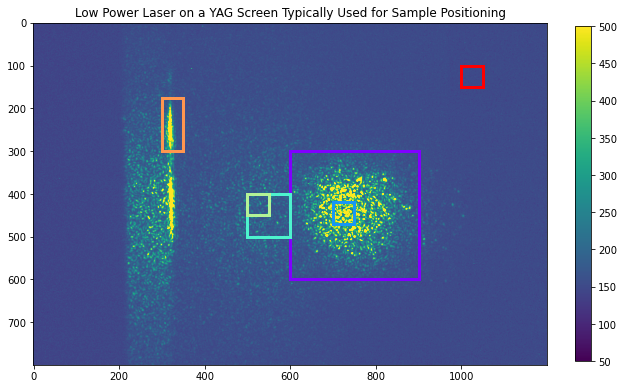

In [16]:
fig, ax = plt.subplots(figsize=(10,15))
im = ax.imshow(imgs[0],vmax=500, vmin=50)
cbar = plt.colorbar(im, ax=ax,fraction=.03)
for roi in rois:
    Vpix, Hpix,  Vsize, Hsize = rois[roi]
    rect = patches.Rectangle((Hpix, Vpix), Hsize, Vsize, linewidth=3, edgecolor =next(colors), facecolor='none')     
    ax.add_patch(rect)
fig.savefig('ROIs for Laser Stability Test')
plt.title("Low Power Laser on a YAG Screen Typically Used for Sample Positioning")

In [17]:
#browse_3Darray(imgs)

## Images Emulate X-ray Scattering Measurement
- SAXS diffuse scattering
- Bragg peaks 
- Coherent scattering
- Surface diffraction

## In many cases, one requires "steady" signal over many frames to be averaged together or correlated
- Beam instability (measurement and feedback systems)
- Coherent scattering highly is affected (not just intenisty but X-ray phase or position)
- Potentially aging/damage

## Collect data from time series images for feature engineering -- as similiarly done for the initial training
**STATISTICS FROM ROIS** *(regions of interests)*
- Standard Deviation
- Average Intensity
- Center of Mass X
- Center of Mass Y
- Sigma X (stdev in X)
- Sigma Y (stdev in X)
    
[These and similiar signals are computed by the AreaDetector Stats Plugin](https://areadetector.github.io/master/ADCore/NDPluginStats.html)


### Get the largest `"blob"` roi and calculate statistics

In [18]:
roi = "blob"
Vpix, Hpix,  Vsize, Hsize = rois["blob"]
input_arr = ts.make_input_array(imgs, Vpix, Hpix, Vsize, Hsize)
data_dict = ts.get_data(input_arr, f'{scan}_{roi}',  class_label)
series = pd.Series(data_dict)

In [19]:
series

std_ts                  [140.2709039847577, 140.23791997040794, 140.17...
intensity_ts            [239.8121, 239.78261111111112, 239.56682222222...
com_x_ts                [145.74156090446553, 145.73208709648347, 145.8...
com_y_ts                [146.6928921527405, 146.67826047065316, 146.73...
sigma_x_ts              [86.64754192204654, 86.64801717661025, 86.6461...
sigma_y_ts              [86.68357705529641, 86.68398833876503, 86.6805...
roi_name                                                      154685_blob
classification_label                                              unknown
dtype: object

### Compute 93 features
- higher order correlations of our main statistics
- prepare for entry into our 3 models

In [20]:
features = get_features_single_datum(series) #from  pub-ML_examples.anomaly on github for bnl


In [21]:
df = pd.DataFrame([features])

In [22]:
df

,roi,target,std_ts_ac1,std_ts_ac2,std_ts_ac3,std_ts_ac4,std_ts_pac1,std_ts_pac2,std_ts_pac3,std_ts_diff_ac1,...,sigma_y_ts_diff_ac2,sigma_y_ts_diff_ac3,sigma_y_ts_diff_ac4,sigma_y_ts_start_end,sigma_y_ts_diff_start_end,sigma_y_ts_std,sigma_y_ts_diff_std,intensity_std_ratio,sigma_x_std_ratio,sigma_y_std_ratio
0,154685_blob,unknown,0.695135,0.704158,0.620289,0.63662,0.694586,0.429747,0.105676,-0.514279,...,-0.175995,-0.046523,-0.01142,0.000072,0.000016,0.000029,0.000023,0.93544,1.230879,1.222115


In [23]:
new_data = (df.drop(columns=["target", "roi"]))

### Input data into our models

In [24]:
for method, model in models.items():
    print(f'{method}:\t', end="")
    make_the_model_go(model, new_data)

EE:	The model characterize the data as anomaly
IFT:	The model characterize the data as anomaly
LOD:	The model characterize the data as normal


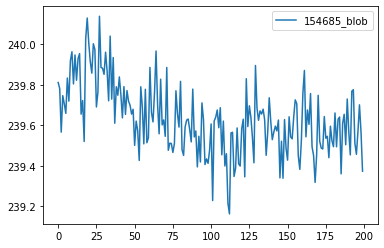

In [25]:
fig = plt.figure()
plt.plot(data_dict['intensity_ts'], label=f'{df["roi"][0]}')#missing first 50')
plt.legend()

In [26]:
roi_list = list(rois.items())

In [27]:
roi_list

[('blob', (300, 600, 300, 300)),
 ('blob_50', (420, 700, 50, 50)),
 ('dif-ref', (400, 500, 100, 100)),
 ('dif-ref_50', (400, 500, 50, 50)),
 ('corner', (175, 300, 125, 50)),
 ('zero', (100, 1000, 50, 50))]

## Applying the same work flow to all ROIs (6)

In [28]:
img_start, img_end = 0, imgs.shape[0] #ALL OF THEM
#img_start, img_end = 50, 150 # just the middle


prediction_results = {'EEpr':[], 'IFTpr':[],'LODpr':[],} 
roi_data_dict = {}

for i, r_list in enumerate(roi_list):
    data, data_dict, meas_label = ts.prep_model_input(imgs[img_start:img_end ], r_list, scan, class_label)
    roi_data_dict.update({i:data_dict})
    for method, model in models.items():
        #print(f'{method}:\t', end="")
        prediction = model.predict(data)
        prediction_results[method+'pr'].append(prediction[0])

In [29]:
df_predictions =  pd.DataFrame(prediction_results)

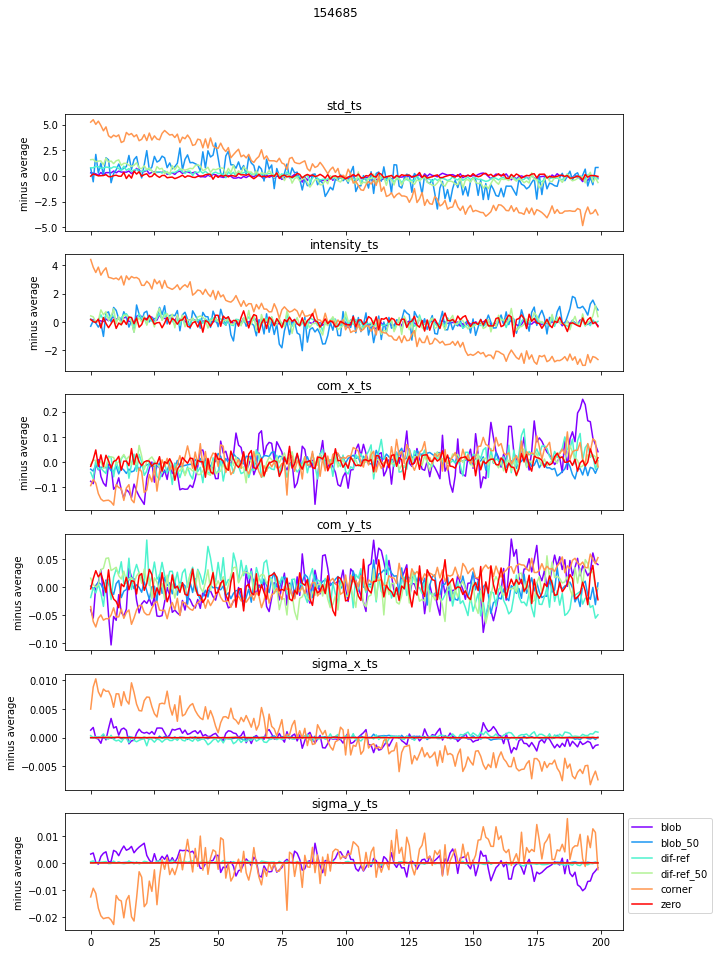

In [30]:
fig, axes = plt.subplots(6, figsize=(10, 15), sharex=True)
plt.suptitle(scan)
for roi_i, data_dict in roi_data_dict.items():
    color = next(colors)
    roi_name, _ = roi_list[roi_i]
    for i, key in enumerate(data_dict.keys()):
        if i < 6:
            ax = axes[i]
            ax.plot((data_dict[key] - np.mean(data_dict[key])), color=color, label = roi_name)
        

for ax, key in zip(axes, data_dict.keys()):
    ax.set(title=key, ylabel = f'minus average')
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel = 'frames'

In [31]:
df_predictions

,EEpr,IFTpr,LODpr
0,-1,-1,1
1,-1,-1,1
2,-1,-1,1
3,-1,-1,1
4,-1,-1,-1
5,1,1,1


### Comment 1 on "no induced" anomalies scan 154685

* LOD looks promising based on `"target"` knowledge
* clear why the corner is characterized as an anomaly
* maybe the we can down select images to have better predictions (50 & 150)?

In [32]:
roi_list

[('blob', (300, 600, 300, 300)),
 ('blob_50', (420, 700, 50, 50)),
 ('dif-ref', (400, 500, 100, 100)),
 ('dif-ref_50', (400, 500, 50, 50)),
 ('corner', (175, 300, 125, 50)),
 ('zero', (100, 1000, 50, 50))]

### Comment 2 on "no induced" anomalies scan 154685

**Using frames = 50:15**
* LOD looks to be most permissive 
* IFT may be more flexible
* EE characteris low intensity, small areas as "no_induced"

# Let's try a different scans
<img src='figures/oops.jpg' width="400" height="400">

```python
0 154685 ['dif_beam_hdf5'] laser stability no induced 
1 154686 ['dif_beam_hdf5'] laser stability slt3 moved ********
2 154687 ['dif_beam_hdf5'] laser stability slt3 move  ********
3 154688 ['dif_beam_hdf5'] laser stability LEDs on/off
4 154689 ['dif_beam_hdf5'] laser stability pinhole move out
5 154690 ['dif_beam_hdf5'] laser stability 0.5 intensity steady (NO INDUCED, but low) ********
6 154691 ['dif_beam_hdf5'] laser stability random up and down intensity
7 154692 ['dif_beam_hdf5'] laser stability >0.5 intensity steady  (NO INDUCED, but low)  ********
8 154693 ['dif_beam_hdf5'] laser stability random up and down intensity
9 154694 ['dif_beam_hdf5'] laser stability sudden off
10 154695 ['dif_beam_hdf5'] laser stability sudden on
11 154696 ['dif_beam_hdf5'] laser stability sudden on
```

In [33]:
scan = scans[2]
class_label = "anomaly" #"no induced"
#class_label = "no induced"
#class_label = None
img_start, img_end = 0, imgs.shape[0] #ALL OF THEM
#img_start, img_end = 50, 150 #ALL OF THEM

run_data = csx[scan]['primary']['data']['dif_beam_hdf5_image'][:, :, 400:1200, :1200].compute()
imgs = ts.get_images_from_tiled(run_data)

In [34]:
prediction_results = {'EEpr':[], 'IFTpr':[],'LODpr':[],}
roi_data_dict = {}
for i, r_list in enumerate(roi_list):
    data, data_dict, meas_label = ts.prep_model_input(imgs[img_start:img_end ], r_list, scan, class_label)
    roi_data_dict.update({i:data_dict})
    for method, model in models.items():
        prediction = model.predict(data)
        prediction_results[method+'pr'].append(prediction[0])

,EEpr,IFTpr,LODpr
0,-1,-1,-1
1,-1,-1,-1
2,-1,-1,-1
3,-1,-1,-1
4,-1,-1,-1
5,1,1,1


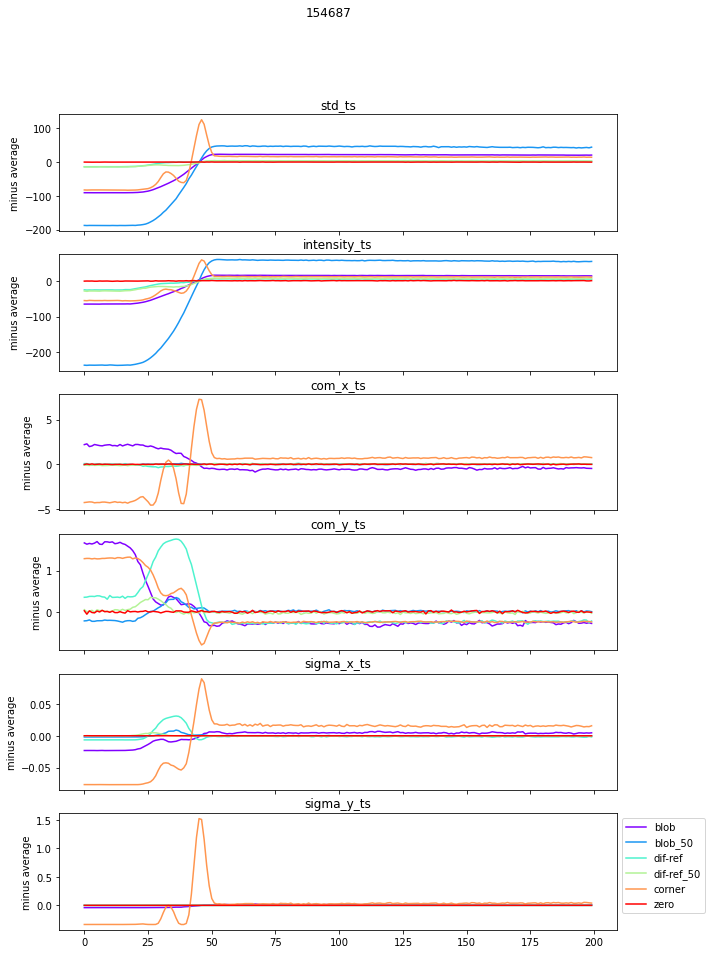

In [35]:
fig, axes = plt.subplots(6, figsize=(10, 15), sharex=True)
plt.suptitle(scan)
for roi_i, data_dict in roi_data_dict.items():
    color = next(colors)
    roi_name, _ = roi_list[roi_i]
    for i, key in enumerate(data_dict.keys()):
        if i < 6:
            ax = axes[i]
            ## NORMALIZED HERE JUST TO SEE PLOTS CLEARLY
            ax.plot((data_dict[key] - np.mean(data_dict[key])), color=color, label = roi_name)
        
for ax, key in zip(axes, data_dict.keys()):
    ax.set(title=key, ylabel = f'minus average')
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel = 'frames'

df_pr_res=pd.DataFrame(prediction_results)
df_pr_res

# And Finally

### Collaborators in the Presented Model
- **Tatiana Konstantinova** *the models in this tutorial*
- Phillip Mafffettone
- Stuart Campbell
- Bruce Ravel
- Daniel Olds

### Collaborators in LDRD 20-038 ”Machine Learning for Real-Time Data Fidelity, Healing, and Analysis for Coherent X-ray Synchrotron Data”
- **Tatiana Konstantinova**
- **Anthony DeGennarro**
- Hui Chen
- Lutz Weigart
- Maksim Rakitin

### General Thanks to Data Science and Systems Integration (DSSI) Program at NSLS-II

The data used in this notebook were collected at the **CSX beamline of the National Synchrotron Light Source II**, a U.S. Department of Energy (DOE) Office of Science User Facility operated for the DOE Office of Science by Brookhaven National Laboratory (BNL) under **Contract No. DE-SC0012704**.